In [1]:
# Install spaCy (if not already installed)
#!pip install spacy

In [2]:
# Install pandas and scikit-learn for data handling and evaluation
#!pip install pandas scikit-learn

In [3]:
# Install nltk for advanced preprocessing
#!pip install nltk wordcloud

In [1]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import spacy
from spacy.pipeline.textcat import Config, single_label_bow_config
from spacy.training import Example
from spacy.util import minibatch, compounding
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [2]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/martawlusek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/martawlusek/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/martawlusek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/martawlusek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Load train.csv
train_data = pd.read_csv("train.csv")

# Display the first few rows to understand the structure
train_data.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# Check for missing values and overall dataset structure
print("Missing values in the dataset:")
print(train_data.isnull().sum())

Missing values in the dataset:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


EDA

In [5]:
# **EDA Section**
print("### Exploratory Data Analysis (EDA) ###")
# Dataset overview
print(f"Dataset Shape: {train_data.shape}")
print(train_data.info())
train_data.describe(include="all")

### Exploratory Data Analysis (EDA) ###
Dataset Shape: (159571, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571,159571,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
unique,159571,159571,NaN,NaN,NaN,NaN,NaN,NaN
top,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,NaN,NaN,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [6]:
# Define input (comments) and output (labels)
X = train_data['comment_text']
y = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]  # Multiple labels for toxicity

# Inspect label distribution
print("Label distribution:")
print(y.value_counts())  # Check class counts

Label distribution:
toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0                143346
1      0             0        0       0       0                  5666
                     1        0       1       0                  3800
                                      0       0                  1758
                     0        0       1       0                  1215
       1             1        0       1       0                   989
       0             1        0       1       1                   618
0      0             1        0       0       0                   317
                     0        0       1       0                   301
1      1             1        0       1       1                   265
0      0             1        0       1       0                   181
1      1             1        0       0       0                   158
       0             0        0       0       1                   136
          

In [7]:
# Split the data (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

# Display the distribution of labels in the training set
print("Training label distribution:")
print(y_train.sum())

# Display the distribution of labels in the validation set
print("Validation label distribution:")
print(y_val.sum())

Training samples: 135635, Validation samples: 23936
Training label distribution:
toxic            13034
severe_toxic      1370
obscene           7170
threat             425
insult            6685
identity_hate     1178
dtype: int64
Validation label distribution:
toxic            2260
severe_toxic      225
obscene          1279
threat             53
insult           1192
identity_hate     227
dtype: int64


Labels in y_train.columns: Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


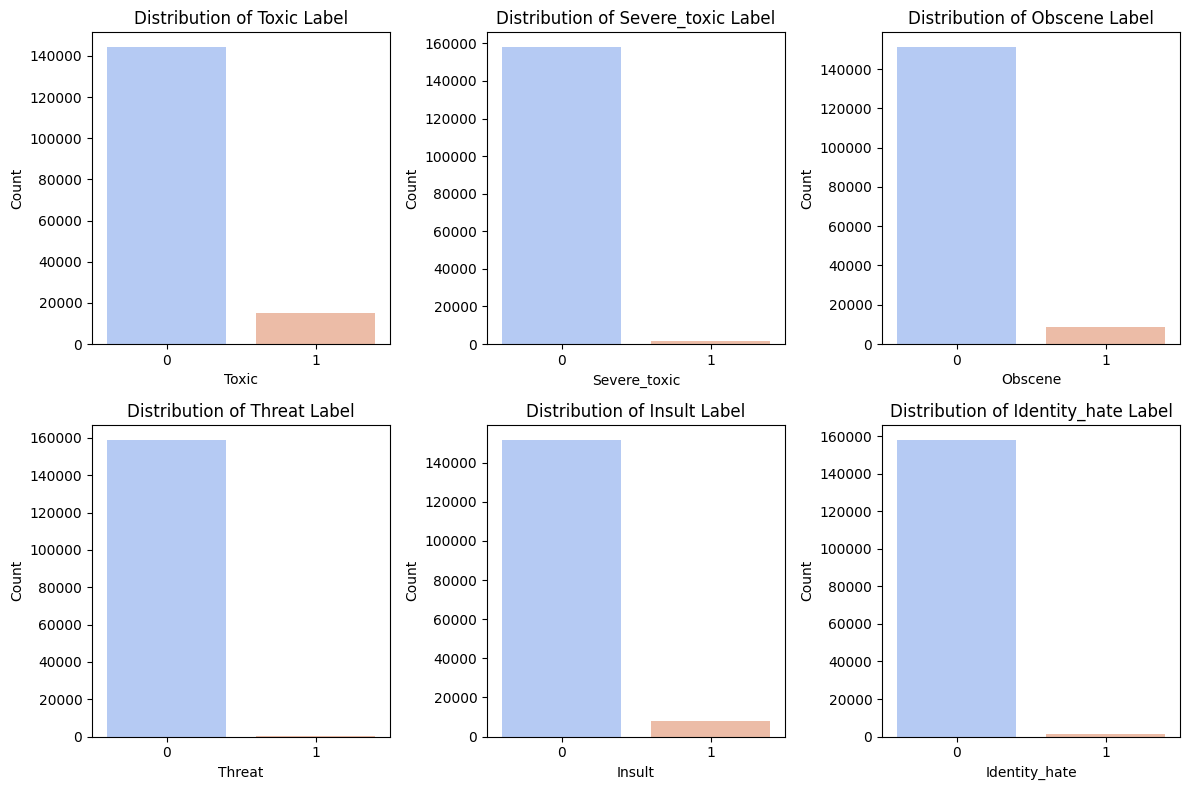

In [8]:
# List of labels
labels = y_train.columns
print(f"Labels in y_train.columns: {labels}")

# Create a bar plot for each label
plt.figure(figsize=(12, 8))

# Iterate over labels and plot distributions
for i, label in enumerate(labels, 1):
    plt.subplot(2, 3, i)  # Arrange plots in a 2x3 grid
    sns.countplot(x=label, data=train_data, hue=label, palette="coolwarm", legend=False)
    plt.title(f"Distribution of {label.capitalize()} Label")
    plt.xlabel(label.capitalize())
    plt.ylabel("Count")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [9]:
# Inspect label distribution
print("Label distribution:")
print(y.sum())  # Check class counts

Label distribution:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


Test 1: UNDERSAMPLING FOR DATA BALANCE

Combined Toxic Labels Distribution:
combined_toxic
0    143346
1     16225
Name: count, dtype: int64


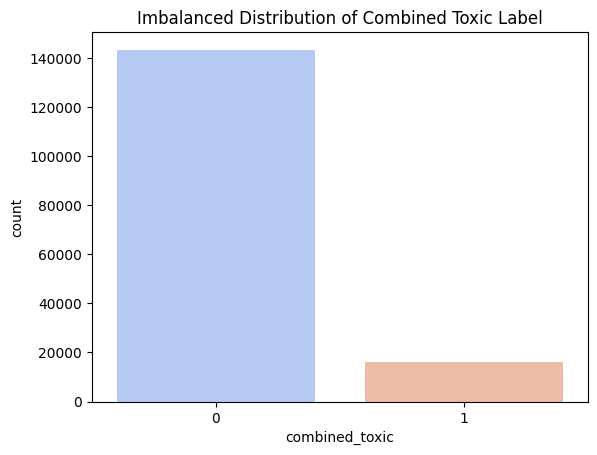

Combined Toxic Labels Distribution:
combined_toxic
1    16225
0    16225
Name: count, dtype: int64


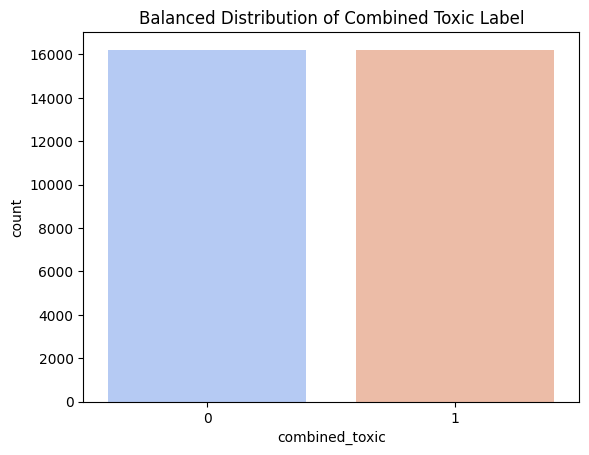

Sample of balanced data:
                                        comment_text  combined_toxic  toxic  \
0      You are an old cougar! You are an old cougar!               1      1   
1            I'm scared\nbrrrr.... i'm gonna die now               0      0   
2  Okay, so anal sex is as widely unaccepted and ...               1      1   
3  shut up you cunt\nWWWWWWWWWWWWWWWWWWWWWWWWWWWW...               1      1   
4  You arrogant administrator homosexual bastards...               1      1   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       1              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        1       0       1              0  
4             1        1       0       1              1  


In [10]:
# Create a 'combined_toxic' label: 1 if any individual label is 1, else 0
train_data['combined_toxic'] = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)

# Verify the new combined label distribution
print("Combined Toxic Labels Distribution:")
print(train_data['combined_toxic'].value_counts())

# Verify the new balanced label distribution
sns.countplot(x='combined_toxic', data=train_data, hue='combined_toxic', palette="coolwarm", legend=False)
plt.title('Imbalanced Distribution of Combined Toxic Label')
plt.show()

# Balance the combined toxic dataset (optional)
# Separate toxic and non-toxic comments
toxic_combined = train_data[train_data['combined_toxic'] == 1]
non_toxic_combined = train_data[train_data['combined_toxic'] == 0]

# Undersample non-toxic class to match the number of toxic samples
non_toxic_combined_undersampled = non_toxic_combined.sample(len(toxic_combined), random_state=42)

# Combine balanced data
balanced_data = pd.concat([toxic_combined, non_toxic_combined_undersampled], axis=0)

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new combined label distribution of balanced data
print("Combined Toxic Labels Distribution:")
print(balanced_data['combined_toxic'].value_counts())

# Verify the new balanced label distribution
sns.countplot(x='combined_toxic', data=balanced_data, hue='combined_toxic', palette="coolwarm", legend=False)
plt.title('Balanced Distribution of Combined Toxic Label')
plt.show()

# The dataset now has a 'combined_toxic' label for binary classification
# and the individual labels for multi-label classification
print("Sample of balanced data:")
print(balanced_data[['comment_text', 'combined_toxic', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].head())


In [11]:
# Define input and output for balanced dataset
X_balanced = balanced_data['comment_text']
y_balanced = balanced_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Split into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_balanced, y_balanced, test_size=0.15, random_state=42)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 27582, Validation samples: 4868


In [12]:
# Prepare 'non_toxic' label
train_data['non_toxic'] = ~(train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0).astype(int)

# Convert data into spaCy format
def prepare_spacy_data(comments, labels):
    spacy_data = []
    for comment, label_row in zip(comments, labels.itertuples(index=False)):
        # Create the 'cats' dictionary
        cats = label_row._asdict()  # Convert Pandas row to dictionary
        spacy_data.append((comment, {'cats': cats}))
    return spacy_data

# Prepare training and validation data for multi-label classification
train_data_spacy = prepare_spacy_data(X_train, y_train)
val_data_spacy = prepare_spacy_data(X_val, y_val)

# Print a sample of the processed data
print("Sample processed data (spaCy format):")
print(train_data_spacy[:3])

Sample processed data (spaCy format):
[("First of all, what the fuck does homosexuality have to do with anything?  Are you seriously that homophobic?  Ejaculation appeals to women too, but you don't mention women, that was highly fucking bizarre.  Secondly, Wikipedia is not censored, and shouldn't be.  If your school cannot realize that Wiki serves as an encyclopedia (of sorts) on the web, then that's too bad.  I'm sure if you added some pictures that served as a purpose, and backed them up, there would be no problem.  And I highly doubt you've done such things; it just seems like you came here to rant about gay people, and THEN make it seem like it all went together. 71.59.189.46", {'cats': {'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 1}}), ("GET READY, JJ137... \n\n...TO EAT SMEGMA FOR BREAKFAST, LUNCH AND DINNER.\n\nTOO BAD YOU FUCKED WITH ME, CAUSE NOW I'M GONNA PUT A FOOT IN YOUR ASS, BITCH", {'cats': {'toxic': 1, 'severe_toxic': 0, 'obs

WORDCLOUDS FOR UNCLEANED DATA

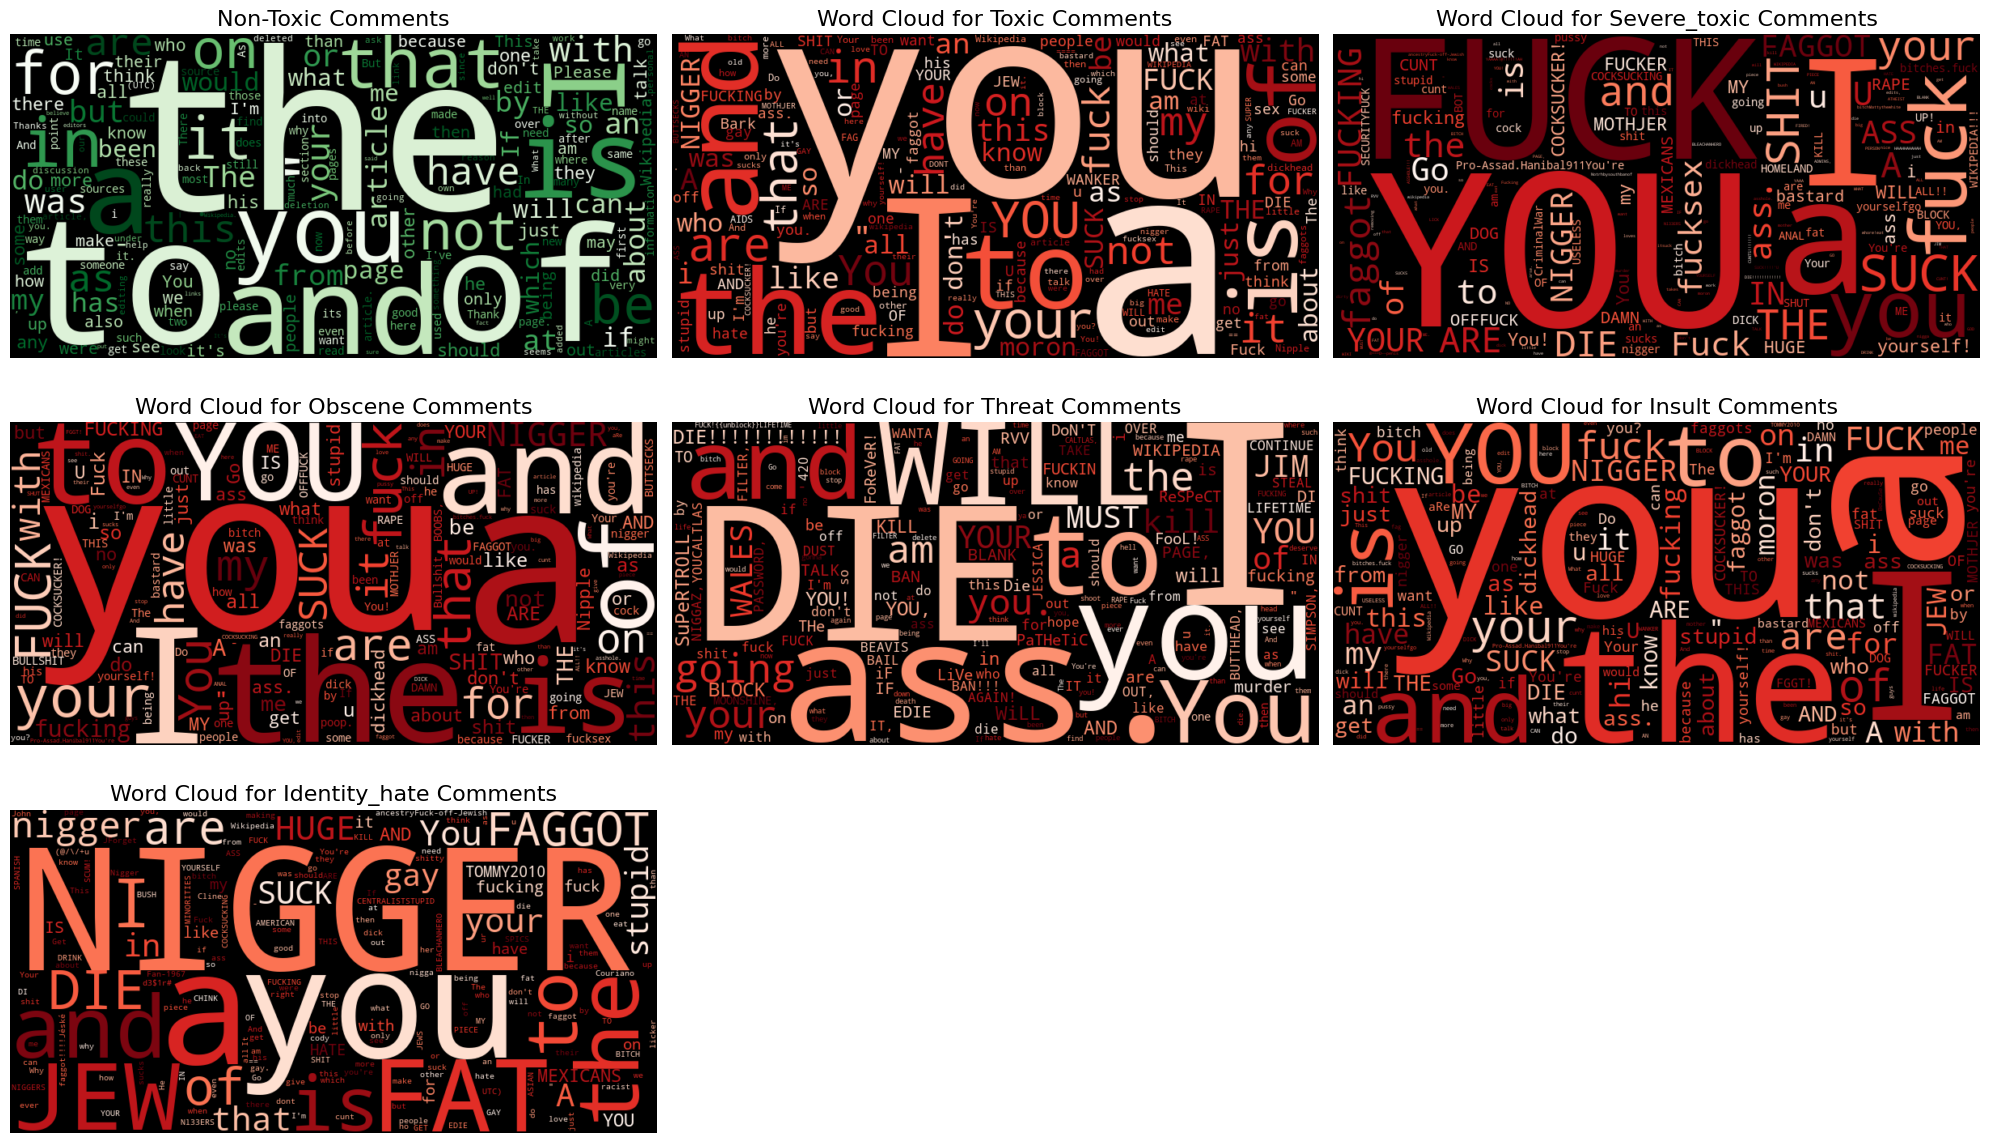

In [13]:

# Generate word clouds for each label
def generate_wordclouds_for_labels(train_data, labels):
    wordclouds = {}
    for label in labels:
        # Filter comments for the current label
        label_comments = train_data[labels[label] == 1]
        # Calculate word frequencies
        text = " ".join(label_comments)
        word_frequencies = Counter(text.split())
        # Generate word cloud from frequencies
        wordclouds[label] = WordCloud(
            width=800, height=400, background_color='black', colormap='Reds'
        ).generate_from_frequencies(word_frequencies)
    return wordclouds

# Combine all non-toxic comments for word cloud
non_toxic_comments = X_train[y_train.sum(axis=1) == 0]  # Non-toxic means no labels are 1
non_toxic_text = " ".join(non_toxic_comments)
non_toxic_frequencies = Counter(non_toxic_text.split())

non_toxic_wordcloud = WordCloud(
    width=800, height=400, background_color='black', colormap='Greens'
).generate_from_frequencies(non_toxic_frequencies)

# Generate word clouds for toxic labels
labels = y_train.columns
wordclouds = generate_wordclouds_for_labels(X_train, y_train)

# Plot the word clouds
plt.figure(figsize=(20, 12))

# Non-toxic word cloud
plt.subplot(3, 3, 1)
plt.imshow(non_toxic_wordcloud, interpolation='bilinear')
plt.title("Non-Toxic Comments", fontsize=16)
plt.axis("off")

# Toxic labels word clouds
for i, label in enumerate(labels, start=2):
    plt.subplot(3, 3, i)
    plt.imshow(wordclouds[label], interpolation='bilinear')
    plt.title(f"Word Cloud for {label.capitalize()} Comments", fontsize=16)
    plt.axis("off")

plt.tight_layout()
plt.show()

CLEANING AND PREPROCESSING

In [14]:
# **Enhanced Preprocessing using NLTK**
def preprocess_text_nltk(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\s+", " ", text)  # Remove extra whitespaces
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply enhanced preprocessing to training and validation data
X_train_cleaned = X_train.apply(preprocess_text_nltk)
X_val_cleaned = X_val.apply(preprocess_text_nltk)

# Prepare spaCy data again with cleaned text
train_data_spacy = prepare_spacy_data(X_train_cleaned, y_train)
val_data_spacy = prepare_spacy_data(X_val_cleaned, y_val)

print("Sample cleaned data (spaCy format):")
print(train_data_spacy[:3])

Sample cleaned data (spaCy format):
[('first fuck homosexuality anything seriously homophobic ejaculation appeal woman dont mention woman highly fucking bizarre secondly wikipedia censored shouldnt school realize wiki serf encyclopedia sort web thats bad im sure added picture served purpose backed would problem highly doubt youve done thing seems like came rant gay people make seem like went together 715918946', {'cats': {'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 1}}), ('get ready jj137 eat smegma breakfast lunch dinner bad fucked cause im gon na put foot as bitch', {'cats': {'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 0}}), ('source cited article always reliableabc news popular science esquire magazine anyone think source legitimate wikipedia standard severe reading comprehension problem vandalizing legitimate wikipedia entry im requesting desist way thats nonnegotiable', {'cats': {'toxic': 0, 's

WORDCLOUDS FOR CLEANED DATA

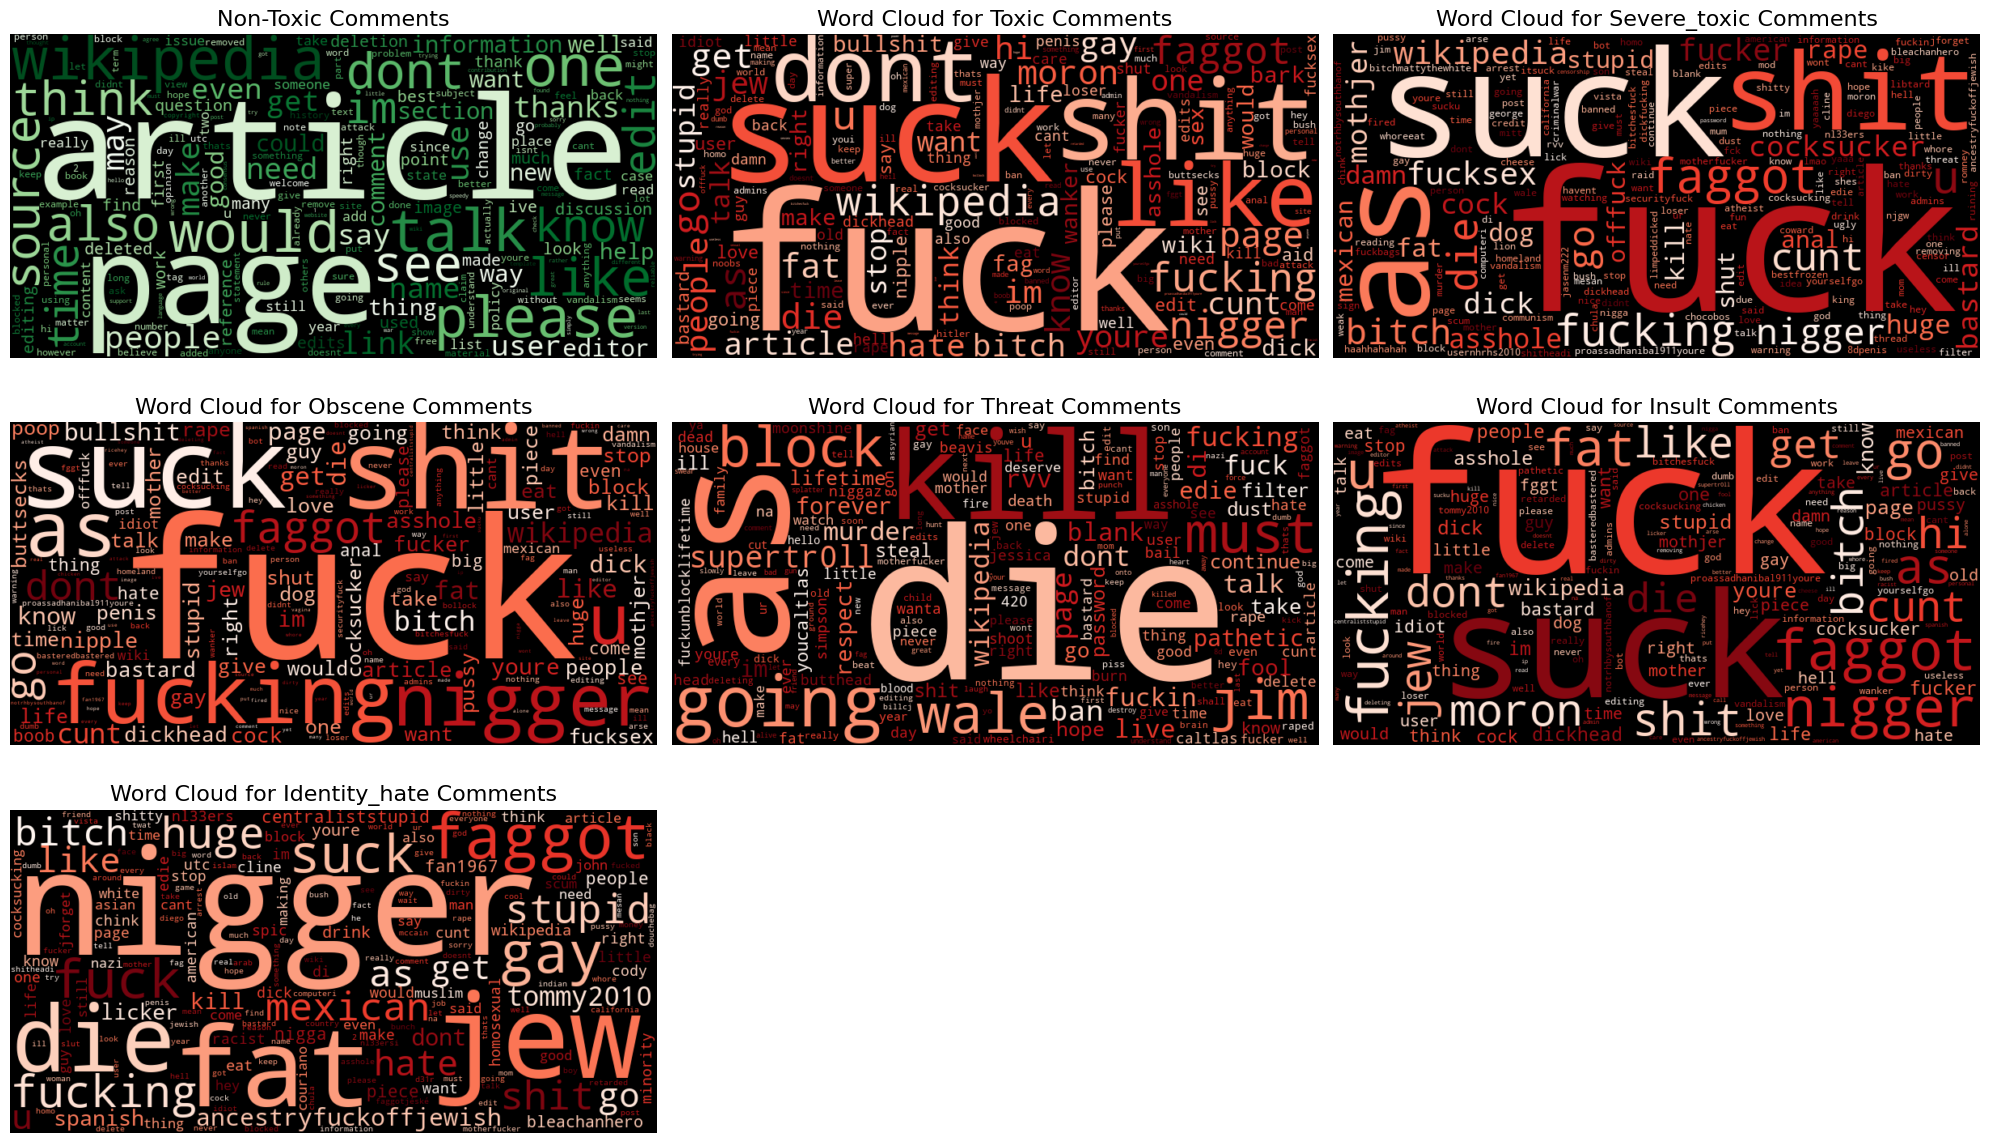

In [16]:
# Generate word clouds for each label using the cleaned data
def generate_wordclouds_for_labels(cleaned_data, labels):
    wordclouds = {}
    for label in labels:
        # Filter comments for the current label
        label_comments = cleaned_data[labels[label] == 1]
        # Count word frequencies
        text = " ".join(label_comments)
        word_frequencies = Counter(text.split())
        # Generate word cloud from frequencies
        wordclouds[label] = WordCloud(
            width=800, height=400, background_color='black', colormap='Reds'
        ).generate_from_frequencies(word_frequencies)
    return wordclouds

# Combine all non-toxic comments for word cloud
non_toxic_comments = X_train_cleaned[y_train.sum(axis=1) == 0]  # Non-toxic means no labels are 1
non_toxic_text = " ".join(non_toxic_comments)
non_toxic_frequencies = Counter(non_toxic_text.split())

non_toxic_wordcloud = WordCloud(
    width=800, height=400, background_color='black', colormap='Greens'
).generate_from_frequencies(non_toxic_frequencies)

# Generate word clouds for toxic labels
labels = y_train.columns
wordclouds = generate_wordclouds_for_labels(X_train_cleaned, y_train)

# Plot the word clouds
plt.figure(figsize=(20, 12))

# Non-toxic word cloud
plt.subplot(3, 3, 1)
plt.imshow(non_toxic_wordcloud, interpolation='bilinear')
plt.title("Non-Toxic Comments", fontsize=16)
plt.axis("off")

# Toxic labels word clouds
for i, label in enumerate(labels, start=2):
    plt.subplot(3, 3, i)
    plt.imshow(wordclouds[label], interpolation='bilinear')
    plt.title(f"Word Cloud for {label.capitalize()} Comments", fontsize=16)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [18]:
# Save processed data to files (optional)
# import json

# with open("train_data_spacy.json", "w") as f:
#     json.dump(train_data_spacy, f)

# with open("val_data_spacy.json", "w") as f:
#     json.dump(val_data_spacy, f)

# print("Preprocessed data saved as JSON files.")

In [17]:
# Create a blank spaCy pipeline for English
nlp = spacy.blank("en")

# Print a confirmation
print("Blank spaCy pipeline created.")


Blank spaCy pipeline created.


The configuring a multi-label text classification pipeline contains the following components:

Tok2Vec: This handles tokenization and embedding of the text. MultiHashEmbed is used for word embeddings and MaxoutWindowEncoder for encoding the token embeddings.

Linear Model: The TextCatBOW model is set up for bag-of-words based classification. The exclusive_classes=False option is used, which is correct for multi-label classification.

In [18]:
config = {
    "threshold": 0.5,  # Classification threshold
    "model": {
        "@architectures": "spacy.TextCatEnsemble.v2",
        "tok2vec": {
            "@architectures": "spacy.Tok2Vec.v2",
            "embed": {
                "@architectures": "spacy.MultiHashEmbed.v2",
                "width": 64,
                "rows": [2000, 2000, 500, 1000, 500],
                "attrs": ["NORM", "LOWER", "PREFIX", "SUFFIX", "SHAPE"],
                "include_static_vectors": False,
            },
            "encode": {
                "@architectures": "spacy.MaxoutWindowEncoder.v2",
                "width": 64,
                "window_size": 1,
                "maxout_pieces": 3,
                "depth": 2,
            },
        },
        "linear_model": {
            "@architectures": "spacy.TextCatBOW.v3",
            "exclusive_classes": False,  # Multi-label classification
            "ngram_size": 1,
            "no_output_layer": False,
            "length": 262144,  # Add length explicitly to avoid further errors
        },
    },
}

# Add the multi-label spaCy text categorizer (textcat_multilabel)
textcat = nlp.add_pipe("textcat_multilabel", config=config)

analysis = nlp.analyze_pipes(pretty=True)
print(analysis)

# Add labels (categories) to the text categorizer
for label in labels:  
    textcat.add_label(label)
    print(f"Added label: {label}")


============================= Pipeline Overview =============================

#   Component            Assigns    Requires   Scores            Retokenizes
-   ------------------   --------   --------   ---------------   -----------
0   textcat_multilabel   doc.cats              cats_score        False      
                                               cats_score_desc              
                                               cats_micro_p                 
                                               cats_micro_r                 
                                               cats_micro_f                 
                                               cats_macro_p                 
                                               cats_macro_r                 
                                               cats_macro_f                 
                                               cats_macro_auc               
                                               cats_f_per_type           

In [19]:
# **** Early Stopping ****

# Calculate class weights based on frequency
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train.values), y=y_train.values.flatten())
#class_weights_dict = dict(zip(y_train.columns, class_weights))  # Map class labels to class weights

# Initialize optimizer
optimizer = nlp.begin_training()

# Early stopping parameters
best_val_loss = float('inf')
patience = 3  # Number of epochs to wait for improvement
patience_counter = 0
max_epochs = 20

# Training loop
for epoch in range(max_epochs):  # Use a large max_epochs value
    random.shuffle(train_data_spacy)
    losses = {}
    
    # Training phase
    batches = minibatch(train_data_spacy, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        examples = [Example.from_dict(nlp.make_doc(text), {"cats": annotations["cats"]}) for text, annotations in batch]
        nlp.update(examples, drop=0.5, losses=losses)
    
    print(f"Epoch {epoch + 1}, Loss: {losses['textcat_multilabel']}")
    
    # Validation phase
    val_loss = 0
    for text, annotations in val_data_spacy:
        # Process text with the model
        doc = nlp(text)
        
        # Manual loss calculation
        for label in annotations["cats"]:
            true_value = annotations["cats"][label]
            predicted_value = doc.cats[label]
            val_loss += (true_value - predicted_value) ** 2  # Squared error loss
    
    # Normalize validation loss by the number of validation examples
    val_loss /= len(val_data_spacy)
    
    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}")
    
    # Check early stopping criteria
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter
        # Save the best model
        nlp.to_disk("best_model")
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

Epoch 1, Loss: 201.9948555668816
Epoch 1, Validation Loss: 0.3458
Epoch 2, Loss: 117.81200672016712
Epoch 2, Validation Loss: 0.3210
Epoch 3, Loss: 99.836895528686
Epoch 3, Validation Loss: 0.3138
Epoch 4, Loss: 87.25211525140912
Epoch 4, Validation Loss: 0.3175
Epoch 5, Loss: 77.02031156772318
Epoch 5, Validation Loss: 0.3190
Epoch 6, Loss: 69.74489577632812
Epoch 6, Validation Loss: 0.3247
Early stopping triggered at epoch 6


In [24]:
# Collect predictions and true labels
true_labels = []
pred_labels = []

# Loop through the validation data (with multi-labels)
for text, annotations in val_data_spacy:  # val_data_spacy is a list of (text, annotations)
    # Convert the text and annotations into an Example
    example = spacy.training.Example.from_dict(nlp.make_doc(text), {"cats": annotations["cats"]})
    
    # Process the text with the model
    doc = nlp(example.text)
    
    # Collect the predictions for each label, including 'non_toxic'
    pred_labels.append({label: doc.cats[label] for label in doc.cats})
    
    # Collect the true labels for each label, including 'non_toxic'
    true_labels.append({label: annotations["cats"][label] for label in annotations["cats"]})

# Convert predictions to binary based on threshold
threshold = 0.6
pred_binary = [
    {label: int(score >= threshold) for label, score in pred.items()}
    for pred in pred_labels
]

# Extract the keys (categories/labels) in a consistent order
categories = list(true_labels[0].keys())  # Includes all labels, including 'non_toxic'

# Convert dictionaries to 2D arrays for sklearn
true_array = np.array([[label_dict[cat] for cat in categories] for label_dict in true_labels])
pred_array = np.array([[label_dict[cat] for cat in categories] for label_dict in pred_binary])

# Evaluate using sklearn's classification report for multi-label classification
print(classification_report(true_array, pred_array, target_names=categories, zero_division=1))

               precision    recall  f1-score   support

        toxic       0.92      0.81      0.86      2269
 severe_toxic       0.59      0.08      0.14       251
      obscene       0.85      0.83      0.84      1248
       threat       1.00      0.00      0.00        74
       insult       0.79      0.63      0.70      1189
identity_hate       0.60      0.17      0.26       186

    micro avg       0.86      0.70      0.78      5217
    macro avg       0.79      0.42      0.47      5217
 weighted avg       0.85      0.70      0.75      5217
  samples avg       0.94      0.84      0.82      5217



In [25]:
# Collect predictions and true labels including non_toxic
true_labels = []
pred_labels = []

# Loop through the validation data (with multi-labels)
for text, annotations in val_data_spacy:  # val_data_spacy is a list of (text, annotations)
    # Convert the text and annotations into an Example
    example = spacy.training.Example.from_dict(nlp.make_doc(text), {"cats": annotations["cats"]})
    
    # Process the text with the model
    doc = nlp(example.text)
    
    # Collect predictions for all labels, including 'non_toxic'
    predicted_cats = {label: doc.cats[label] for label in doc.cats}
    
    # Calculate 'non_toxic' for predictions
    predicted_cats['non_toxic'] = int(all(doc.cats[label] < 0.5 for label in doc.cats if label != 'non_toxic'))
    
    # Collect true labels for all categories, including 'non_toxic'
    true_cats = annotations["cats"].copy()
    true_cats['non_toxic'] = int(all(annotations["cats"][label] == 0 for label in annotations["cats"] if label != 'non_toxic'))
    
    # Append predictions and true labels
    pred_labels.append(predicted_cats)
    true_labels.append(true_cats)

# Convert predictions to binary based on threshold
threshold = 0.5
pred_binary = [
    {label: int(score >= threshold) for label, score in pred.items()}
    for pred in pred_labels
]

# Extract the keys (categories/labels) in a consistent order
categories = list(true_labels[0].keys())  # Includes all labels, including 'non_toxic'

# Convert dictionaries to 2D arrays for sklearn
true_array = np.array([[label_dict[cat] for cat in categories] for label_dict in true_labels])
pred_array = np.array([[label_dict[cat] for cat in categories] for label_dict in pred_binary])

# Evaluate using sklearn's classification report for multi-label classification
print(classification_report(true_array, pred_array, target_names=categories, zero_division=1))

               precision    recall  f1-score   support

        toxic       0.90      0.84      0.87      2269
 severe_toxic       0.61      0.20      0.31       251
      obscene       0.84      0.85      0.84      1248
       threat       1.00      0.00      0.00        74
       insult       0.75      0.70      0.72      1189
identity_hate       0.60      0.24      0.34       186
    non_toxic       0.86      0.96      0.90      2457

    micro avg       0.84      0.82      0.83      7674
    macro avg       0.79      0.54      0.57      7674
 weighted avg       0.84      0.82      0.82      7674
  samples avg       0.84      0.84      0.83      7674



In [ ]:
# Load test data and true labels
# test_data = pd.read_csv("test.csv")
# true_labels = pd.read_csv("test_labels.csv")

# # Filter out rows with all -1 labels
# valid_labels = true_labels[~(true_labels.iloc[:, 1:] == -1).all(axis=1)]

# # Load the trained spaCy model
# nlp = spacy.load("best_model")

# # Generate predictions for valid rows
# valid_test_data = test_data[test_data["id"].isin(valid_labels["id"])]
# valid_texts = valid_test_data["comment_text"].tolist()

# predictions = []
# for text in valid_texts:
#     doc = nlp(text)
#     predictions.append(doc.cats)

# # Convert predictions to a DataFrame
# predictions_df = pd.DataFrame(predictions)
# predictions_df["id"] = valid_test_data["id"].values

# # Merge predictions with true labels
# evaluation_df = valid_labels.merge(predictions_df, on="id")

# # Add 'non_toxic' to the true labels (1 if all other labels are 0, else 0)
# true_labels_with_non_toxic = []
# for index, row in evaluation_df.iterrows():
#     true_cats = row[1:7]  # The labels for toxic categories
#     non_toxic = int(all(true_cats == 0))  # non_toxic is 1 if all toxic labels are 0
#     true_labels_with_non_toxic.append(true_cats.tolist() + [non_toxic])

# # Add 'non_toxic' to the predictions (1 if all other labels are < threshold)
# pred_labels_with_non_toxic = []
# threshold = 0.5
# for prediction in predictions:
#     predicted_cats = prediction
#     non_toxic = int(
#         all(predicted_cats[label] < threshold for label in predicted_cats if label != 'non_toxic')
#     )
#     pred_labels_with_non_toxic.append([predicted_cats[label] for label in predicted_cats] + [non_toxic])

# # Convert the lists of true and predicted labels into arrays for classification_report
# y_true = np.array(true_labels_with_non_toxic)
# y_pred = np.array(pred_labels_with_non_toxic)

# # Define the categories including 'non_toxic'
# categories = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate", "non_toxic"]

# # Evaluate the model using classification_report
# report = classification_report(y_true, y_pred > threshold, target_names=categories, zero_division=1)  # Threshold 0.5

# print(report)

In [ ]:
# Generate confusion matrices
# for idx, category in enumerate(categories):
#     # Compute confusion matrix for the current label
#     cm = confusion_matrix(y_true[:, idx], (y_pred[:, idx] > threshold).astype(int))  # Apply threshold to predictions
    
#     # Create a heatmap
#     plt.figure(figsize=(6, 5))
#     sns.heatmap(
#         cm,
#         annot=True,
#         fmt="d",
#         cmap="Blues",
#         xticklabels=["Not " + category, category],
#         yticklabels=["Not " + category, category]
#     )
#     plt.title(f"Confusion Matrix for {category}")
#     plt.ylabel("True Label")
#     plt.xlabel("Predicted Label")
#     plt.show()

In [2]:
# Assuming val_data_spacy is a list of (text, annotations) where annotations include 'id'
ids = [annotations["id"] for _, annotations in val_data_spacy]  # Extract IDs from annotations

# Convert pred_binary to a DataFrame
pred_df = pd.DataFrame(pred_binary)

# Add the IDs to the predictions DataFrame
pred_df.insert(0, "id", ids)

# Ensure the column order matches your desired format
pred_df = pred_df[["id"] + categories]  # Categories include only toxic labels

# Save to CSV
pred_df.to_csv("evaluation_scores.csv", index=False)

print("Predictions saved to evaluation_scores.csv")

NameError: name 'val_data_spacy' is not defined